In [1]:
import numpy as np
import pandas as pd
import os

## Import Libraries

In [8]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from colorama import Fore, Back, Style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from mlxtend.plotting import plot_confusion_matrix

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as gobj
import plotly.figure_factory as ff

from statsmodels.formula.api import ols

import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")


# Explore Data

In [9]:
heart_data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
heart_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


- Sex : Male = 1 // Female = 0
- Age : Age of patient
- Diabetes : No = 0 // Yes = 1
- High_blood_pressure : No = 0 // Yes = 1
- Smoking : No = 0 // Yes = 1
- DEATH_EVENT : No = 0 // Yes = 1

# Does Age and Sex have relation between Death Event?

In [10]:
hist_data = [heart_data['age'].values]
group_labels=['age']

fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text = 'Age Distribution plot')

fig.show()

- Age wise 40~80 spreads high
- Less than 40, more than 80 age have very few counts

In [11]:
fig = px.box(heart_data, x='sex', y='age', points='all')
fig.update_layout(title_text='Gender wise Age Spread - Male = 1 / Female = 0')
fig.show()

In [12]:
male_survived = heart_data[(heart_data['sex']==1)&(heart_data['DEATH_EVENT']==0)]
male_dead = heart_data[(heart_data['sex']==1)&(heart_data['DEATH_EVENT']==1)]
female_survived = heart_data[(heart_data['sex']==0)&(heart_data['DEATH_EVENT']==0)]
female_dead = heart_data[(heart_data['sex']==0)&(heart_data['DEATH_EVENT']==1)]

labels = ['Male-Survived', 'Male-Dead', 'Female-Survived', 'Female-Dead']
values = [len(male_survived), len(male_dead), len(female_survived), len(female_dead)]

fig = go.Figure(data = [go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(title_text = 'Gender Survival')
fig.show()

# Gender Factor Analysis

In [13]:
survive = heart_data[heart_data['DEATH_EVENT']==0]['age']
dead = heart_data[heart_data['DEATH_EVENT']==1]['age']

hist_data = [survive, dead]
group_labels = ['Survived', 'Dead']

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(title_text='Analysis in Age with Survival Status')
fig.show()

- People dead are going through all ages
- Survival rate is high on (40~70)

In [27]:
fig = px.violin(heart_data, y='age', x='smoking', color='DEATH_EVENT', box=True, points='all', hover_data=heart_data.columns)
fig.update_layout(title_text = 'Analysis in Age & Smoking on Survival Status')
fig.show()

print("Pepole Dead, Smoking",len(heart_data[(heart_data['smoking']==1)&(heart_data['DEATH_EVENT']==1)]))
print("People Dead, No Smoking", len(heart_data[(heart_data['smoking']==0)&(heart_data['DEATH_EVENT']==1)]))

Pepole Dead, Smoking 30
People Dead, No Smoking 66


- High Survival Rate on (Not Smoking age 55~65 ) & (Smoking age 50~60)
- People who doesn't smoke is higher than people who smokes in this data.....  ??????

In [30]:
fig = px.violin(heart_data, y='age', x='diabetes', color='DEATH_EVENT', box=True, points='all', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Age & Diabetes on Survival Status')
fig.show()

# Other Factors

In [32]:
fig = px.histogram(heart_data, x='creatinine_phosphokinase', color='DEATH_EVENT', marginal='violin', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Creatinine_phosphokinase on Survival Status')
fig.show()

- Less Creatinine_phosphokinase can cause death

In [33]:
fig = px.histogram(heart_data, x='ejection_fraction', color='DEATH_EVENT', marginal='violin', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Ejection Fraction on Survival Status')
fig.show()

In [35]:
fig = px.histogram(heart_data, x='platelets', color='DEATH_EVENT', marginal='violin', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Platelets on Survival Status')
fig.show()

In [36]:
heart_data.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [37]:
fig = px.histogram(heart_data, x='serum_creatinine', color='DEATH_EVENT', marginal='violin', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Serum Creatinine on Survival Status')
fig.show()

In [40]:
survived = heart_data[heart_data['DEATH_EVENT']==0]['serum_creatinine']
dead = heart_data[heart_data['DEATH_EVENT']==1]['serum_creatinine']

hist_data = [survived, dead]
group_labels = ['Survived', 'Dead']

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(title_text='Analysis in Serum Creatinine on Survival Status')
fig.show()

In [38]:
fig = px.histogram(heart_data, x='serum_sodium', color='DEATH_EVENT', marginal='violin', hover_data=heart_data.columns)
fig.update_layout(title_text='Analysis in Serum Sodium on Survival Status')
fig.show()

In [39]:
survived = heart_data[heart_data['DEATH_EVENT']==0]['serum_sodium']
dead = heart_data[heart_data['DEATH_EVENT']==1]['serum_sodium']

hist_data = [survived, dead]
group_labels = ['Survived', 'Dead']

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(title_text="Analysis in Serum Sodium on Survival Status")
fig.show()

In [43]:
survived = heart_data[heart_data['DEATH_EVENT']==0]['ejection_fraction']
dead = heart_data[heart_data['DEATH_EVENT']==1]['ejection_fraction']

hist_data = [survived, dead]
group_labels = ['Survived', "Dead"]

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(title_text="Analysis in Ejection Fraction on Survival Status")
fig.show()

- 20~30 % of Ejection Fraction can cause Death
- Higher than 35% have better chance to live

# Pie Charts

In [66]:
def MakePie_Survival(dataset, feature):
    y_survived = dataset[(dataset['DEATH_EVENT']==0) & (dataset[feature]==1)]
    y_dead = dataset[(dataset['DEATH_EVENT']==1) & (dataset[feature]==1)]
    n_survived = dataset[(dataset['DEATH_EVENT']==0) & (dataset[feature]==0)]
    n_dead = dataset[(dataset['DEATH_EVENT']==1) & (dataset[feature]==0)]

    labels = [feature+'-Survived', feature+'-Dead', 'Non '+feature+'-Survived', 'Non '+feature+'-Dead']
    values = [len(y_survived), len(y_dead), len(n_survived), len(n_dead)]

    fig=go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
    fig.update_layout(title_text='Analysis on Survival - ' + feature)
    fig.show()

In [67]:
MakePie_Survival(heart_data, 'diabetes')

- Total of Non Diabetes(174), 118 people survived and 56 people are dead
- Total of Diabetes(125), 85 people survived and 40 people are dead 

In [68]:
MakePie_Survival(heart_data, 'anaemia')

- Total of Non Anaemia(170), 120 people survived and 50 people are dead
- Total of Anaemia(129), 83 people survived and 46 people are dead 

In [69]:
MakePie_Survival(heart_data, 'high_blood_pressure')

- Total of Non High Blood Pressure (194), 137 people survived and 57 people are dead
- Total of High Blood Pressure (105), 66 people survived and 39 people are dead 

In [70]:
MakePie_Survival(heart_data, 'smoking')

- Total of Non Smoking (203), 137 people survived and 66 people are dead
- Total of Smoking (96), 66 people survived and 30 people are dead 

# Heatmap

<AxesSubplot:>

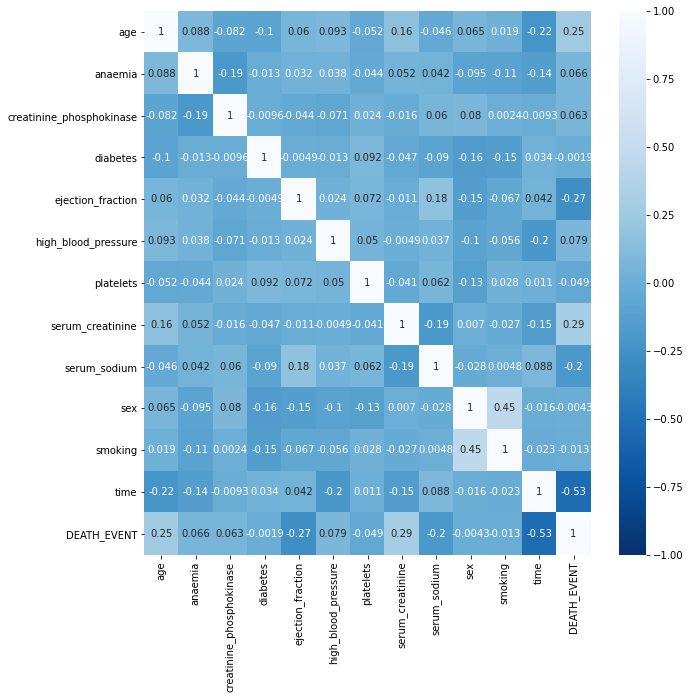

In [75]:
plt.figure(figsize=(10,10))
sns.heatmap(heart_data.corr(), vmin=-1, cmap='Blues_r', annot=True)

- Death Event is related to -> ['Time', 'serum_creatinine', 'Ejection Fraction', 'Age']

# Data Modeling

In [76]:
features = ['time','ejection_fraction','serum_creatinine']

x = heart_data[features]
y = heart_data['DEATH_EVENT']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=2)

In [123]:
accuracy_list=[]

## Logistic Regression

In [124]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)

accuracy_list.append(100*log_reg_acc)

<Figure size 1440x576 with 0 Axes>

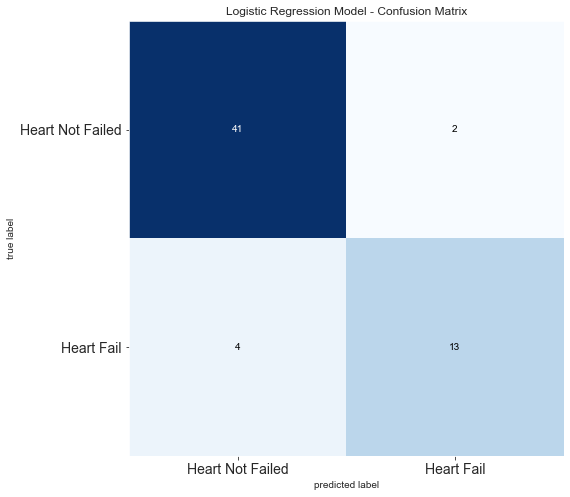

Accuracy (Ground Truth) of Logistic Regression is : 90.00%


In [125]:
cm = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of Logistic Regression is : {:.2f}%".format(100*log_reg_acc) )

## Support Vector

In [126]:
sv_clf = SVC()
sv_clf.fit(x_train,y_train)
sv_clf_pred = sv_clf.predict(x_test)
sv_clf_acc = accuracy_score(y_test, sv_clf_pred)
accuracy_list.append(100 * sv_clf_acc)

<Figure size 1440x576 with 0 Axes>

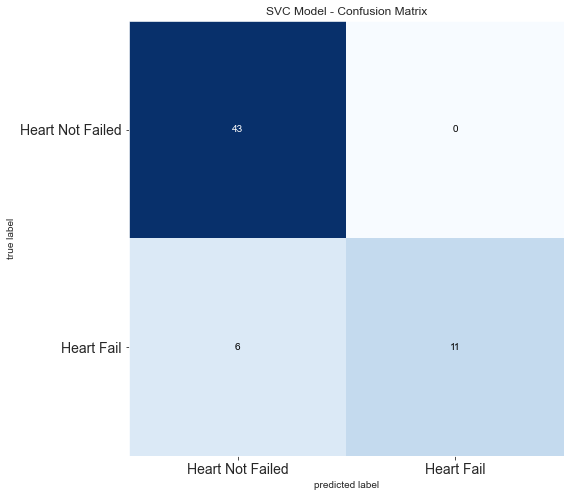

Accuracy (Ground Truth) of SVC is : 90.00%


In [127]:
cm = confusion_matrix(y_test, sv_clf_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVC Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of SVC is :", "{:.2f}%".format(100* sv_clf_acc))

## K-Neighbors Classifier

In [128]:
kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(x_train, y_train)
kn_clf_pred = kn_clf.predict(x_test)
kn_clf_acc = accuracy_score(y_test, kn_clf_pred)
accuracy_list.append( 100*kn_clf_acc)


<Figure size 1440x576 with 0 Axes>

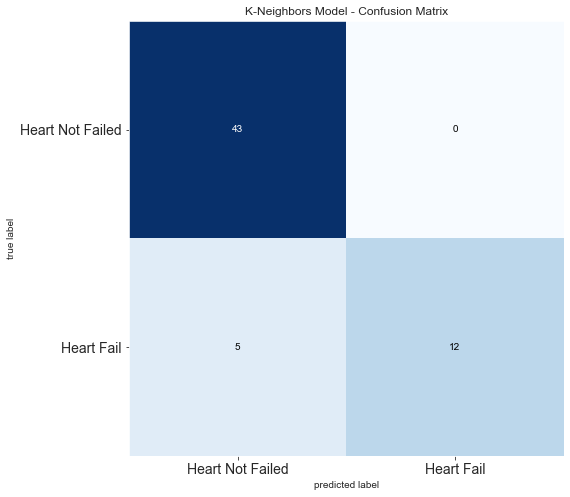

Accuracy (Ground Truth) of K-Neighbors is : 91.67%


In [129]:
cm = confusion_matrix(y_test, kn_clf_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("K-Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of K-Neighbors is :", "{:.2f}%".format(100* kn_clf_acc))

## Decision Tree Classifier

In [130]:
dt_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
dt_clf.fit(x_train, y_train)
dt_clf_pred = dt_clf.predict(x_test)
dt_clf_acc = accuracy_score(y_test, dt_clf_pred)

accuracy_list.append(100*dt_clf_acc)

<Figure size 1440x576 with 0 Axes>

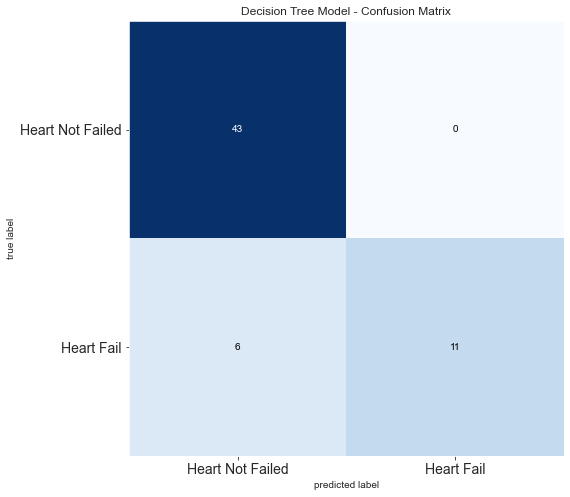

Accuracy (Ground Truth) of Decision Tree Model is : 90.00%


In [131]:
cm = confusion_matrix(y_test, dt_clf_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of Decision Tree Model is :", "{:.2f}%".format(100* dt_clf_acc))

## Random Forest Classifier

<Figure size 1440x576 with 0 Axes>

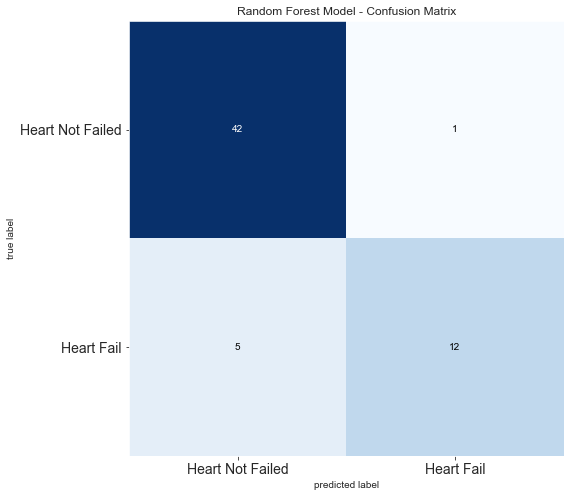

Accuracy (Ground Truth) of Random Forest Model is : 90.00%


In [132]:
r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
r_clf.fit(x_train, y_train)
r_pred = r_clf.predict(x_test)
r_acc = accuracy_score(y_test, r_pred)
accuracy_list.append(100*r_acc)

cm = confusion_matrix(y_test, r_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of Random Forest Model is :", "{:.2f}%".format(100* r_acc))

## Gradient Boosting Classifier

<Figure size 1440x576 with 0 Axes>

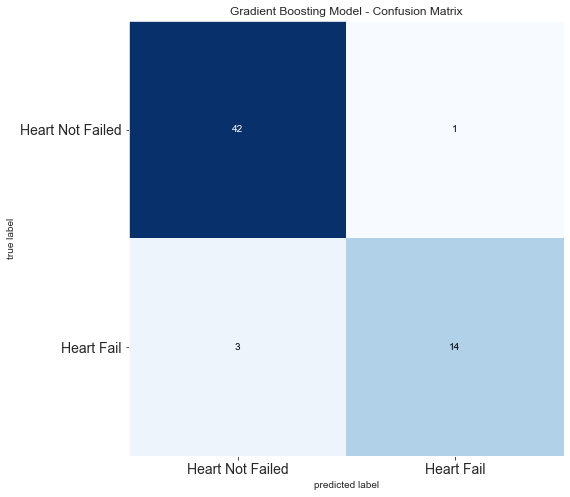

Accuracy (Ground Truth) of Gradient Boosting Model is : 93.33%


In [133]:
gradientboost_clf = GradientBoostingClassifier(max_depth=2, random_state=1)
gradientboost_clf.fit(x_train,y_train)
gradientboost_pred = gradientboost_clf.predict(x_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
accuracy_list.append(100*gradientboost_acc)

cm = confusion_matrix(y_test, gradientboost_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gradient Boosting Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of Gradient Boosting Model is :", "{:.2f}%".format(100* gradientboost_acc))

## xgbrf Classifer


[22:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 1440x576 with 0 Axes>

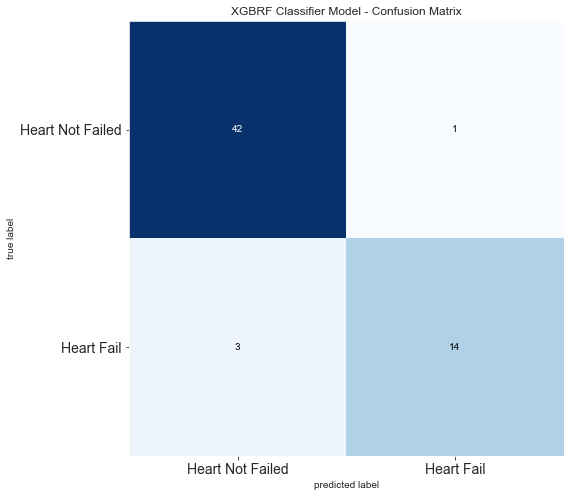

Accuracy (Ground Truth) of XGBRF Classifier Model is : 93.33%


In [134]:
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=1)
xgb_clf.fit(x_train,y_train)
xgb_pred = xgb_clf.predict(x_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_list.append(100*xgb_acc)

cm = confusion_matrix(y_test, xgb_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRF Classifier Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of XGBRF Classifier Model is :", "{:.2f}%".format(100* xgb_acc))

## LGBM Classifier

<Figure size 1440x576 with 0 Axes>

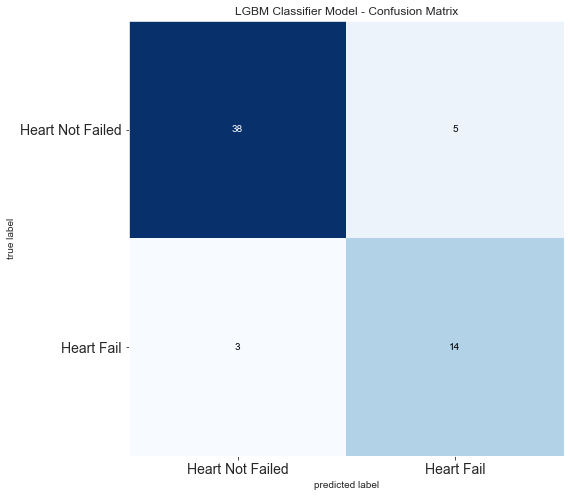

Accuracy (Ground Truth) of LGBM Classifier Model is : 86.67%


In [135]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
lgb_clf.fit(x_train,y_train)
lgb_pred = lgb_clf.predict(x_test)
lgb_acc = accuracy_score(y_test, lgb_pred)
accuracy_list.append(100*lgb_acc)

cm = confusion_matrix(y_test, lgb_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("LGBM Classifier Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of LGBM Classifier Model is :", "{:.2f}%".format(100* lgb_acc))

## CatBoost Classifier

Learning rate set to 0.005591
0:	learn: 0.6898089	total: 3.06ms	remaining: 3.06s
1:	learn: 0.6853691	total: 5.88ms	remaining: 2.93s
2:	learn: 0.6814224	total: 8.5ms	remaining: 2.82s
3:	learn: 0.6763787	total: 10.9ms	remaining: 2.72s
4:	learn: 0.6732323	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6693704	total: 14.7ms	remaining: 2.44s
6:	learn: 0.6649135	total: 16.4ms	remaining: 2.33s
7:	learn: 0.6609337	total: 17.5ms	remaining: 2.17s
8:	learn: 0.6571249	total: 19.8ms	remaining: 2.18s
9:	learn: 0.6521269	total: 21ms	remaining: 2.08s
10:	learn: 0.6485155	total: 22.1ms	remaining: 1.99s
11:	learn: 0.6440567	total: 23.2ms	remaining: 1.91s
12:	learn: 0.6409554	total: 24.6ms	remaining: 1.87s
13:	learn: 0.6370791	total: 25.6ms	remaining: 1.8s
14:	learn: 0.6329117	total: 26.8ms	remaining: 1.76s
15:	learn: 0.6288988	total: 27.9ms	remaining: 1.71s
16:	learn: 0.6246823	total: 29.1ms	remaining: 1.68s
17:	learn: 0.6210250	total: 30.3ms	remaining: 1.65s
18:	learn: 0.6177116	total: 31.2ms	remaining: 1.

<Figure size 1440x576 with 0 Axes>

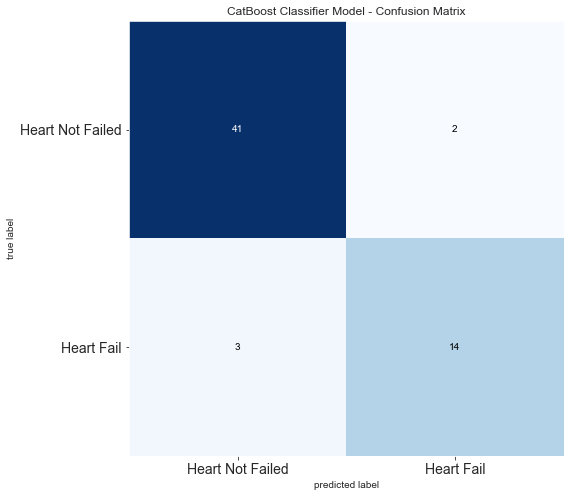

Accuracy (Ground Truth) of CatBoost Classifier Model is : 91.67%


In [136]:
cat_clf = CatBoostClassifier()
cat_clf.fit(x_train,y_train)
cat_pred = cat_clf.predict(x_test)
cat_acc = accuracy_score(y_test, cat_pred)
accuracy_list.append(100*cat_acc)

cm = confusion_matrix(y_test, cat_pred)

plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("CatBoost Classifier Model - Confusion Matrix")
plt.xticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=14)
plt.show()

print(Fore.GREEN + "Accuracy (Ground Truth) of CatBoost Classifier Model is :", "{:.2f}%".format(100* cat_acc))

In [137]:
model_list = ['Logistic Regression', 'SVC','KNearestNeighbours', 'DecisionTree', 'RandomForest',
              'GradientBooster', 'XGBRF','LGBM', 'CatBoostClassifier']

In [138]:
len(model_list)
len(accuracy_list)

9

In [139]:
df = pd.DataFrame({'model_list':model_list, 'accuracy_score':accuracy_list})
df

,model_list,accuracy_score
0,Logistic Regression,90.000000
1,SVC,90.000000
2,KNearestNeighbours,91.666667
3,DecisionTree,90.000000
4,RandomForest,90.000000
5,GradientBooster,93.333333
6,XGBRF,93.333333
7,LGBM,86.666667
8,CatBoostClassifier,91.666667


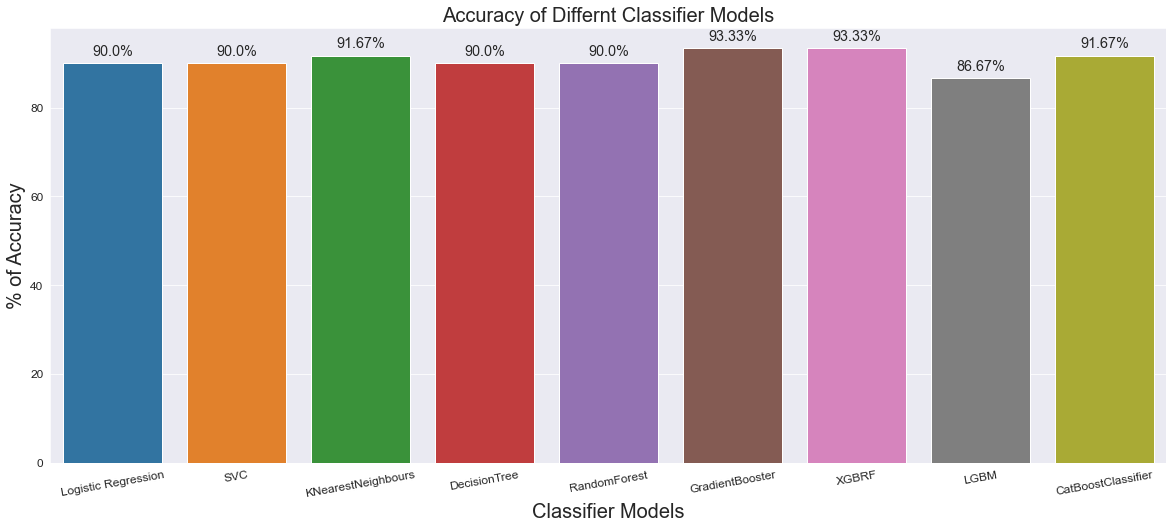

In [143]:
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')

ax = sns.barplot(x=model_list, y=accuracy_list, data=df)

plt.xlabel("Classifier Models", fontsize=20)
plt.ylabel("% of Accuracy", fontsize=20)
plt.title("Accuracy of Differnt Classifier Models", fontsize=20)
plt.xticks(fontsize=12, ha='center', rotation=10)
plt.yticks(fontsize=12)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')

plt.show()

# Reference From Nayan Sakhiya
- https://www.kaggle.com/nayansakhiya